# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68
- private test set:             3005 examples of length=130 and scoring_length=91

### TODO:
- [X] no testing model, one model with different testing and training outputs [+]
- [ ] augmentation
- [X] GCN
- [X] sequence fragmentation and similarieties finding

## Import section

In [1]:
from IPython.display import Markdown as md

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from subgraphing import Subgraphing
from custom_lstm_cell import CustomLSTMCell
from graph_reduce_cell import GraphReduceCell
from submit import *

import time
from datetime import datetime

In [2]:
%load_ext tensorboard

# Data Loading

In [3]:
%time train_valid_ds, public_test_ds, private_test_ds = get_datasets()

CPU times: user 2.53 s, sys: 658 ms, total: 3.19 s
Wall time: 3.25 s


### Inspect tf.data.Dataset's columns

In [5]:
print('train_valid_ds:')
inspect_dataset_columns(train_valid_ds)
print('\n\n\n')

print('public_test_ds:')
inspect_dataset_columns(public_test_ds)
print('\n\n\n')

print('private_test_ds:')
inspect_dataset_columns(private_test_ds)
print('\n\n\n')

train_valid_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: 2400




public_test_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 68)"
4,edges_features_matrix,"(68, 68, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 14)"


dataset cardinality: 629




private_test_ds:
FEATURES:


,feature_name,tensor_shape
0,sequence,"(91, 4)"
1,structure,"(91, 3)"
2,predicted_loop_type,"(91, 7)"
3,adjacency_matrix,"(91, 91)"
4,edges_features_matrix,"(91, 91, 3)"
5,seq_scored,()
6,stacked_base_features,"(91, 14)"


dataset cardinality: 3005






# Model

In [6]:
print(f"feature_names: {FEATURE_NAMES}")
print(f"error_label_names: {ERROR_LABEL_NAMES}")
print(f"normal_label_names: {NORMAL_LABEL_NAMES}")
print(f"all_label_names: {ALL_LABEL_NAMES}")
print(f"scored_label_names: {SCORED_LABEL_NAMES}")

feature_names: ['sequence', 'structure', 'predicted_loop_type', 'adjacency_matrix', 'edges_features_matrix', 'seq_scored']
error_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
normal_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
all_label_names: ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
scored_label_names: ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']


### definition

In [7]:
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 20
UNITS = 64

In [8]:
def subgraph_dataset(ds, neighbourhood_size):
    def subgraphing_map_fn(*args):
        if len(args) == 2:
            x, y = args
        else:
            x = args[0]

        base_inputs = x['stacked_base_features']
        adjacency_matrix_inputs = x['adjacency_matrix']
        edges_features_matrix_inputs = x['edges_features_matrix']
        inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

        subgraphed = Subgraphing(neighbourhood_size)(inputs)

        subgraphed_base_inputs, subgraphed_adjacency_matrix_inputs, subgraphed_edges_features_matrix_inputs = subgraphed
        x['stacked_base_features'] = subgraphed_base_inputs
        x['adjacency_matrix'] = subgraphed_adjacency_matrix_inputs
        x['edges_features_matrix'] = subgraphed_edges_features_matrix_inputs

        if len(args) == 2:
            return x, y
        else:
            return x
    return ds.batch(1).map(subgraphing_map_fn).unbatch().cache()

In [9]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth, units):
    base_inputs = Input(shape = (None, neighbourhood_size, stacked_features_size), name='stacked_base_features')
    adjacency_matrix_inputs = Input(shape=(neighbourhood_size, None, None), name='adjacency_matrix')
    edges_features_matrix_inputs = Input(shape=(neighbourhood_size, None, None, edges_features_matrix_depth), name='edges_features_matrix')

    inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

    x = RNN(GraphReduceCell(units), return_sequences=True)(inputs)

    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
    outputs = {'stacked_scored_labels': stacked_scored_outputs}

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [10]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

### Instantiation

In [11]:
model = create_model_for_subgraphed_dataset(NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE, EDGES_FEATURES_MATRIX_DEPTH, UNITS)

log_dir = os.path.join(os.getcwd(), 'logs')
model_name = datetime.now().strftime('model_%Y_%m_%d__%H_%M_%S')
model_log_dir = os.path.join(log_dir, model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=0, update_freq='epoch')

model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

### Inspection

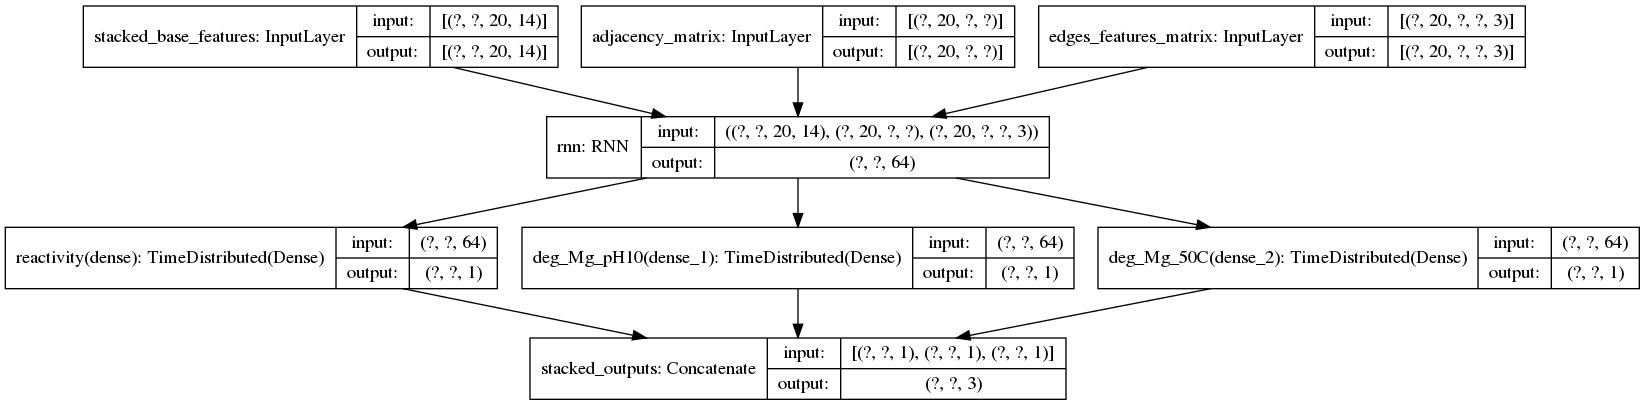

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Additional dataset preparations

Datasets shapes

In [13]:
image_name = 'datasets_shapes.jpg'
md(f"![title]({image_name})")

![title](datasets_shapes.jpg)

In [13]:
train_ds, valid_ds = split_into_train_and_valid(train_valid_ds, split_factor=0.3)

In [14]:
subgraphed_train_ds = subgraph_dataset(train_ds, NEIGHBOURHOOD_SIZE)
inspect_dataset_columns(subgraphed_train_ds)

subgraphed_valid_ds = subgraph_dataset(valid_ds, NEIGHBOURHOOD_SIZE)
inspect_dataset_columns(subgraphed_valid_ds)

subgraphed_public_test_ds = subgraph_dataset(public_test_ds, NEIGHBOURHOOD_SIZE)
inspect_dataset_columns(subgraphed_public_test_ds)

subgraphed_private_test_ds = subgraph_dataset(private_test_ds, NEIGHBOURHOOD_SIZE)
inspect_dataset_columns(subgraphed_private_test_ds)

FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"



LABELS:


,label_name,tensor_shape
0,stacked_scored_labels,"(68, 3)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(68, 4)"
1,structure,"(68, 3)"
2,predicted_loop_type,"(68, 7)"
3,adjacency_matrix,"(68, 20, 20)"
4,edges_features_matrix,"(68, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(68, 20, 14)"


dataset cardinality: -2
FEATURES:


,feature_name,tensor_shape
0,sequence,"(91, 4)"
1,structure,"(91, 3)"
2,predicted_loop_type,"(91, 7)"
3,adjacency_matrix,"(91, 20, 20)"
4,edges_features_matrix,"(91, 20, 20, 3)"
5,seq_scored,()
6,stacked_base_features,"(91, 20, 14)"


dataset cardinality: -2


### Baseline training and testing models evaluation

In [17]:
model.evaluate(subgraphed_valid_ds.batch(64))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


12/12 [==============================] - 21s 2s/step - loss: 0.7125


0.7124933004379272

# Model training

In [16]:
%tensorboard --logdir $log_dir

'/home/jan/kaggle_competitions/covid/logs/model_2020_10_02__14_06_52'

In [16]:
history = model.fit(subgraphed_train_ds.batch(32),
                    validation_data=subgraphed_valid_ds.batch(128),
                    epochs=10,
                    initial_epoch=0,
                    verbose=1,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/10


/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


      1/Unknown - 0s 173us/step - loss: 0.9689WARNING:tensorflow:From /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
     18/Unknown - 20s 1s/step - loss: 0.6466

KeyboardInterrupt: 

### Shape sanity checks

In [24]:
def get_predictions(ds, model):
    prediction_ds = ds.batch(64)
    predictions = model.predict(prediction_ds)['stacked_scored_labels']
    return predictions

In [25]:
predictions_1 = get_predictions(subgraphed_train_ds, model)
print(predictions_1.shape)

(1680, 68, 3)


In [26]:
predictions_3 = get_predictions(subgraphed_public_test_ds, model)
print(predictions_3.shape)

(629, 68, 3)


In [27]:
predictions_5 = get_predictions(subgraphed_private_test_ds, model)
print(predictions_5.shape)

(3005, 91, 3)


### Important Note

Training and testing models share same layers. The difference is that training model has fixed output sequence length (68) due to training - it has to be this.
On the other hand testing model output_sequence length is equal to the input sequence length.
So the training model is used the training and testing model benefits from it. Moreover testing model allows to create submissions.

Submission containes predictions for all positions in sequences. Moreover it contains two parts:
- submission created out of public test set - seqlen: 107, scoring length: 68
- submission created out of private test set - seqlen: 130, scoring length: 91
Testing model is able to create predictions for both public and private test set because it has not set sequence dimension

# Create submission

In [29]:
start = time.time()
submission = create_submission(model, [subgraphed_public_test_ds, subgraphed_private_test_ds], [raw_public_test_ds, raw_private_test_ds])
end = time.time()
print(end - start)
submission

6.061823129653931


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.571527,0.608852,0.0,0.663545,0.0
1,id_00073f8be_1,0.571527,0.608852,0.0,0.663545,0.0
2,id_00073f8be_2,0.571527,0.608852,0.0,0.663545,0.0
3,id_00073f8be_3,0.571527,0.608852,0.0,0.663545,0.0
4,id_00073f8be_4,0.571527,0.608852,0.0,0.663545,0.0
...,...,...,...,...,...,...
316222,id_ffda94f24_86,0.459479,0.535269,0.0,0.559879,0.0
316223,id_ffda94f24_87,0.486060,0.551273,0.0,0.603195,0.0
316224,id_ffda94f24_88,0.486060,0.551273,0.0,0.603195,0.0
316225,id_ffda94f24_89,0.486060,0.551273,0.0,0.603195,0.0


In [30]:
submission_name = 'submission.csv'
submission_path = os.path.join(os.getcwd(), submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [19]:
model_file_name = 'model'
model_path = os.path.join(os.getcwd(), model_file_name)

In [31]:
# model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse})

In [32]:
# model.save(model_path)

TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining - wuju ogarnia
* SequenceGenerator:
    - propably delete it, but if not:
    - SequenceGenerator wrapper fix get_config
    - SequenceGenerator fix rnn.units handling in case of nested wrapper (e.g. Bidirectional)
    - rewrite